# Import

In [27]:
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [28]:
# %%
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..', ''))
other_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'Other_Agents'))
sys.path.append(parent_dir)
sys.path.append(other_dir)

In [29]:
# %%
from Game_Env import LeducholdemEnv
from Random_Agent import RandomAgent
from Aggressive_Agent import AggressiveAgent
from Passive_Agent import PassiveAgent
from NonICM_EA_MCCFR_Agent import NonICM_EA_MCCFR_Agent
from NonICM_TA_MCCFR_Agent import NonICM_TA_MCCFR_Agent

# Env setting and agents loading

In [30]:
"""Set up the environment for the competition with the provided configuration."""
def env_set(config):
    env = LeducholdemEnv(config=config)
    print(">> Matches environment and game configures set.")
    return env

"""Load agents with the provided model paths into the given environment."""
def load_agents(env, model_paths):
    '''
    Parameters:
        - env: The environment where the agents will be loaded.
        - model_paths: A dictionary containing the model paths for the agents.
    Returns:
        A dictionary of loaded agents.
    '''
    player_ea = NonICM_EA_MCCFR_Agent(env, model_path=model_paths['player_ea'])
    player_ea.load()
    
    player_ta = NonICM_TA_MCCFR_Agent(env, model_path=model_paths['player_ta'])
    player_ta.load()
    
    player_agg = AggressiveAgent(num_actions=4)
    player_pass = PassiveAgent(num_actions=4)
    player_random = RandomAgent(num_actions=4)  # Initialize random agent, can be used later if needed

    print(">> Agents loaded.")
    return {
        'player_ea': player_ea,
        'player_ta': player_ta,
        'player_agg': player_agg,
        'player_pass': player_pass,
        'player_random': player_random
    }

"""Set the agents for the environment.""" 
def set_agents(env, agents):
    '''
    Parameters:
    - env: The environment where the agents will be set.
    - agents: A list of agents to be set in the environment.
    '''
    env.set_agents(agents)
    print(f">> {type(agents[0])} and {type(agents[1])} set in environment.")

# Match function

In [31]:
# 1. Initialize wealth and win counters for each iteration
# 2. Check if either player needs to be reset before starting a new round
# 3. Append cumulative wealth to lists
# 4. Small blind setting

def matches_run(rounds, hands, env, initial_chips, small_blind_multiplier):
    # 
    all_p1_wealth = {}
    all_p2_wealth = {}
    all_p1_wins = {}
    all_p2_wins = {}
    all_p1_wins_prob = {}
    all_p2_wins_prob = {}
    all_p1_payoffs = {}
    all_p2_payoffs = {}
    all_trajectories = {}

    for i in range(rounds):
        
        # Initialize wealth and win counters for each iteration
        p1_wealth = initial_chips
        p2_wealth = initial_chips
        p1_wins = 0
        p2_wins = 0
        p1_wealth_list = []
        p2_wealth_list = []
        small_blind = 1
        p1_payoffs = []
        p2_payoffs = []
        trajectories_list =[]
        
        while len(p1_wealth_list) < hands:
            # Check if either player needs to be reset before starting a new hand
            if not (p1_wealth > 0 and p2_wealth > 0 and p1_wealth > small_blind * 8 and p2_wealth > small_blind * 8):
                p1_wealth = initial_chips
                p2_wealth = initial_chips
                small_blind = 1
            
            # 设置当前轮的盲注
            env.game.small_blind = small_blind
            env.game.big_blind = 2 * small_blind
            env.game.raise_amount = env.game.big_blind

            # 运行游戏
            trajectories, payoffs = env.run(is_training=False)
            p1_payoffs.append(payoffs[0])
            p2_payoffs.append(payoffs[1])
            trajectories_list.append(trajectories)

            # 计算赢局数
            if payoffs[0] > 0:
                p1_wins += 1
            else:
                p2_wins += 1

            # 更新财富值
            p1_wealth += payoffs[0]
            p2_wealth += payoffs[1]

            # Append cumulative wealth to lists
            p1_wealth_list.append(p1_wealth)
            p2_wealth_list.append(p2_wealth)

            # Double the small blind
            small_blind *= small_blind_multiplier
            # small_blind = min(max(p1_wealth,p2_wealth)*0.02,small_blind*small_blind_multiplier)

        all_p1_wealth[i+1] = p1_wealth_list
        all_p2_wealth[i+1] = p2_wealth_list
        all_p1_wins[i+1] = p1_wins
        all_p2_wins[i+1] = p2_wins
        all_p1_wins_prob[i+1] = p1_wins/(p1_wins+p2_wins)
        all_p2_wins_prob[i+1] = p2_wins/(p1_wins+p2_wins)
        all_p1_payoffs[i+1] = p1_payoffs
        all_p2_payoffs[i+1] = p2_payoffs
        all_trajectories[i+1] = trajectories_list

    print(">> Competition finished.")
    return all_p1_wealth, all_p2_wealth, all_p1_wins, all_p2_wins, all_p1_wins_prob, all_p2_wins_prob, all_p1_payoffs, all_p2_payoffs, all_trajectories



 # Match - EA vs TA

In [32]:
env = env_set(config={'allow_step_back':True,
                'small_blind': 1,
                'allowed_raise_num': 2,
                'seed':42})

model_paths = {
    'player_ea': './nonicm_ea_mccfr_agent',
    'player_ta': './nonicm_ta_mccfr_agent',
    'player_normal': './nonicm_mccfr_agent',
}
agents = load_agents(env, model_paths)

set_agents(env, [agents['player_ea'], agents['player_ta']])

#  Run matches
all_p1_wealth, all_p2_wealth, all_p1_wins, all_p2_wins, all_p1_wins_prob, all_p2_wins_prob, all_p1_payoffs, all_p2_payoffs, all_trajectories = matches_run(rounds=20,hands=1000,env=env,initial_chips=1000,small_blind_multiplier=1)

>> Matches environment and game configures set.
>> Agents loaded.
>> <class 'NonICM_EA_MCCFR_Agent.NonICM_EA_MCCFR_Agent'> and <class 'NonICM_TA_MCCFR_Agent.NonICM_TA_MCCFR_Agent'> set in environment.
>> Competition finished.


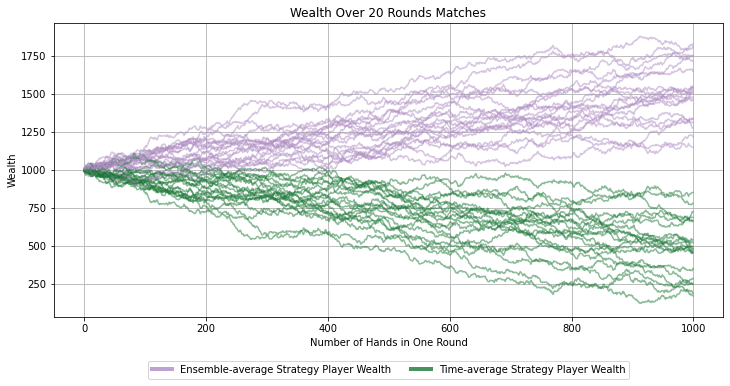

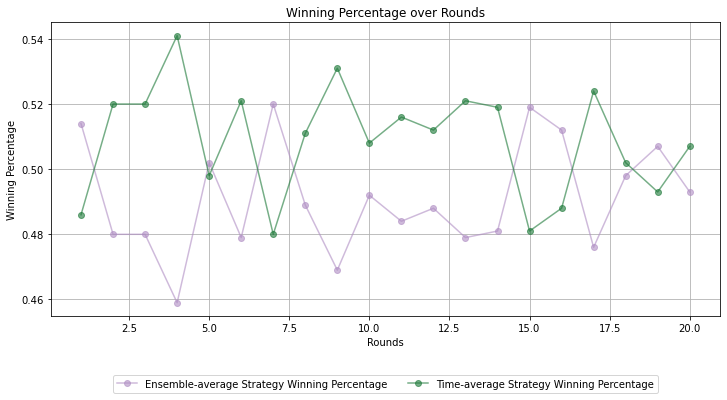

In [33]:
# %%
# Line plot for wealth change

plt.figure(figsize=(12, 6))

for round_num in all_p1_wealth:
    plt.plot(all_p1_wealth[round_num], color='#af8dc3', alpha=0.5)
    plt.plot(all_p2_wealth[round_num], color='#1b7837', alpha=0.5)
custom_lines = [
    Line2D([0], [0], color='#af8dc3', lw=4, alpha=0.8),
    Line2D([0], [0], color='#1b7837', lw=4, alpha=0.8)
]
plt.legend(custom_lines, ['Ensemble-average Strategy Player Wealth', 'Time-average Strategy Player Wealth'], 
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, borderaxespad=0.)

plt.title(f'Wealth Over {len(all_p1_wealth)} Rounds Matches')
plt.xlabel('Number of Hands in One Round')
plt.ylabel('Wealth')
plt.subplots_adjust(bottom=0.2)
plt.grid(True)
plt.show()


# Line plot for win prob.
# data preparation

round_nums = list(all_p1_wins_prob.keys())
p1_win_probs = [all_p1_wins_prob[round_num] for round_num in round_nums]
p2_win_probs = [all_p2_wins_prob[round_num] for round_num in round_nums]
# fig
plt.figure(figsize=(12, 6))
plt.plot(round_nums, p1_win_probs, label='Ensemble-average Strategy Winning Percentage', color='#af8dc3', marker='o',alpha=0.6)
plt.plot(round_nums, p2_win_probs, label='Time-average Strategy Winning Percentage', color='#1b7837', marker='o',alpha=0.6)

plt.title(f'Winning Percentage over Rounds')
plt.xlabel('Rounds')
plt.ylabel('Winning Percentage')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2, borderaxespad=0.)
plt.subplots_adjust(bottom=0.2)
plt.grid(True)
plt.show()


 # Match - EA vs Random

In [34]:
# Set up
env = env_set(config={'allow_step_back':True,
                'small_blind': 1,
                'allowed_raise_num': 2,
                'seed':42})

model_paths = {
    'player_ea': './nonicm_ea_mccfr_agent',
    'player_ta': './nonicm_ta_mccfr_agent',
    'player_normal': './nonicm_mccfr_agent',
}
agents = load_agents(env, model_paths)

set_agents(env, [agents['player_ea'], agents['player_random']])

#  Run matches
all_p1_wealth, all_p2_wealth, all_p1_wins, all_p2_wins, all_p1_wins_prob, all_p2_wins_prob, all_p1_payoffs, all_p2_payoffs, all_trajectories = matches_run(rounds=20,hands=1000,env=env,initial_chips=1000,small_blind_multiplier=1)


>> Matches environment and game configures set.
>> Agents loaded.
>> <class 'NonICM_EA_MCCFR_Agent.NonICM_EA_MCCFR_Agent'> and <class 'Random_Agent.RandomAgent'> set in environment.
>> Competition finished.


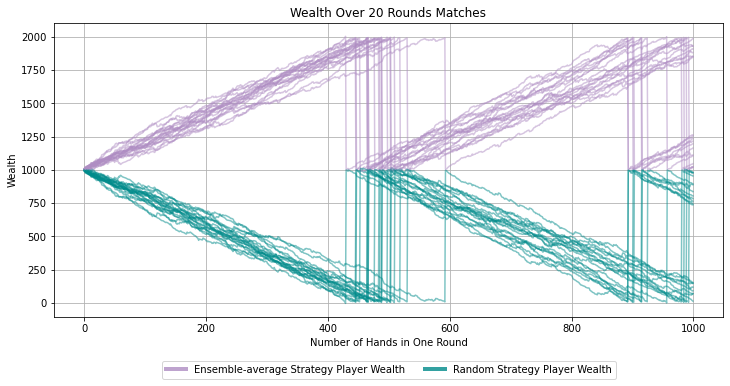

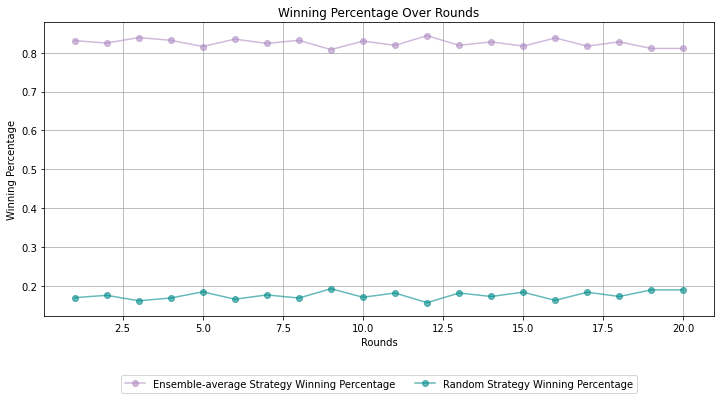

In [35]:
# Line plot for wealth change
plt.figure(figsize=(12, 6))

for round_num in all_p1_wealth:
    plt.plot(all_p1_wealth[round_num], color='#af8dc3', alpha=0.5)
    plt.plot(all_p2_wealth[round_num], color='darkcyan', alpha=0.5)
custom_lines = [
    Line2D([0], [0], color='#af8dc3', lw=4, alpha=0.8),
    Line2D([0], [0], color='darkcyan', lw=4, alpha=0.8)
]
plt.legend(custom_lines, ['Ensemble-average Strategy Player Wealth', 'Random Strategy Player Wealth'], 
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, borderaxespad=0.)

plt.title(f'Wealth Over {len(all_p1_wealth)} Rounds Matches')
plt.xlabel('Number of Hands in One Round')
plt.ylabel('Wealth')
plt.subplots_adjust(bottom=0.2)
plt.grid(True)
plt.show()


# Line plot for win prob.
# data preparation
round_nums = list(all_p1_wins_prob.keys())
p1_win_probs = [all_p1_wins_prob[round_num] for round_num in round_nums]
p2_win_probs = [all_p2_wins_prob[round_num] for round_num in round_nums]

# fig
plt.figure(figsize=(12, 6))
plt.plot(round_nums, p1_win_probs, label='Ensemble-average Strategy Winning Percentage', color='#af8dc3', marker='o',alpha=0.6)
plt.plot(round_nums, p2_win_probs, label='Random Strategy Winning Percentage', color='darkcyan', marker='o',alpha=0.6)

plt.title('Winning Percentage Over Rounds')
plt.xlabel('Rounds')
plt.ylabel('Winning Percentage')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2, borderaxespad=0.)
plt.subplots_adjust(bottom=0.2)
plt.grid(True)
plt.show()

 # Play game - EA vs Aggressive

In [36]:
# Set up
env = env_set(config={'allow_step_back':True,
                'small_blind': 1,
                'allowed_raise_num': 2,
                'seed':42})

model_paths = {
    'player_ea': './nonicm_ea_mccfr_agent',
    'player_ta': './nonicm_ta_mccfr_agent',
}
agents = load_agents(env, model_paths)

set_agents(env, [agents['player_ea'], agents['player_agg']])

#  Run matches
all_p1_wealth, all_p2_wealth, all_p1_wins, all_p2_wins, all_p1_wins_prob, all_p2_wins_prob, all_p1_payoffs, all_p2_payoffs, all_trajectories = matches_run(rounds=20,hands=1000,env=env,initial_chips=1000,small_blind_multiplier=1)

>> Matches environment and game configures set.
>> Agents loaded.
>> <class 'NonICM_EA_MCCFR_Agent.NonICM_EA_MCCFR_Agent'> and <class 'Aggressive_Agent.AggressiveAgent'> set in environment.
>> Competition finished.


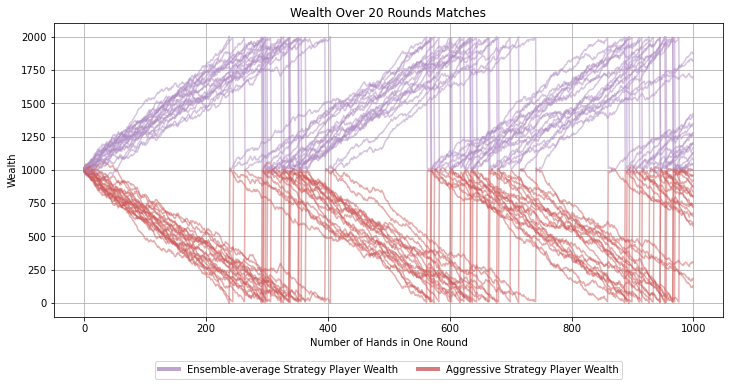

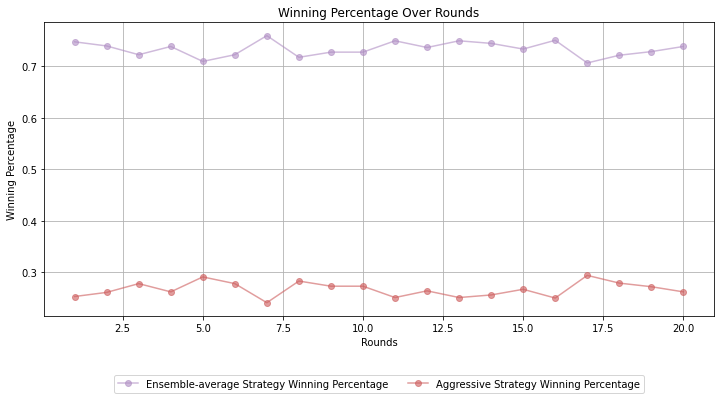

In [37]:
# Line plot for wealth change

plt.figure(figsize=(12, 6))

for round_num in all_p1_wealth:
    plt.plot(all_p1_wealth[round_num], color='#af8dc3', alpha=0.5)
    plt.plot(all_p2_wealth[round_num], color='indianred', alpha=0.5)
custom_lines = [
    Line2D([0], [0], color='#af8dc3', lw=4, alpha=0.8),
    Line2D([0], [0], color='indianred', lw=4, alpha=0.8)
]
plt.legend(custom_lines, ['Ensemble-average Strategy Player Wealth', 'Aggressive Strategy Player Wealth'], 
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, borderaxespad=0.)

plt.title(f'Wealth Over {len(all_p1_wealth)} Rounds Matches')
plt.xlabel('Number of Hands in One Round')
plt.ylabel('Wealth')
plt.subplots_adjust(bottom=0.2)
plt.grid(True)
plt.show()


# Line plot for win prob.
# data preparation

round_nums = list(all_p1_wins_prob.keys())
p1_win_probs = [all_p1_wins_prob[round_num] for round_num in round_nums]
p2_win_probs = [all_p2_wins_prob[round_num] for round_num in round_nums]
# fig
plt.figure(figsize=(12, 6))
plt.plot(round_nums, p1_win_probs, label='Ensemble-average Strategy Winning Percentage', color='#af8dc3', marker='o',alpha=0.6)
plt.plot(round_nums, p2_win_probs, label='Aggressive Strategy Winning Percentage', color='indianred', marker='o',alpha=0.6)

plt.title('Winning Percentage Over Rounds')
plt.xlabel('Rounds')
plt.ylabel('Winning Percentage')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2, borderaxespad=0.)
plt.subplots_adjust(bottom=0.2)
plt.grid(True)
plt.show()


In [38]:
# Set up
env = env_set(config={'allow_step_back':True,
                'small_blind': 1,
                'allowed_raise_num': 2,
                'seed':42})

model_paths = {
    'player_ea': './nonicm_ea_mccfr_agent',
    'player_ta': './nonicm_ta_mccfr_agent',
}
agents = load_agents(env, model_paths)

set_agents(env, [agents['player_ea'], agents['player_pass']])

#  Run matches
all_p1_wealth, all_p2_wealth, all_p1_wins, all_p2_wins, all_p1_wins_prob, all_p2_wins_prob, all_p1_payoffs, all_p2_payoffs, all_trajectories = matches_run(rounds=20,hands=1000,env=env,initial_chips=1000,small_blind_multiplier=1)

>> Matches environment and game configures set.
>> Agents loaded.
>> <class 'NonICM_EA_MCCFR_Agent.NonICM_EA_MCCFR_Agent'> and <class 'Passive_Agent.PassiveAgent'> set in environment.
>> Competition finished.


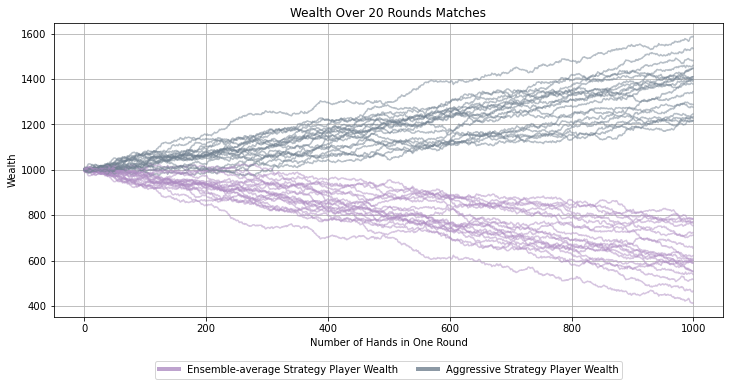

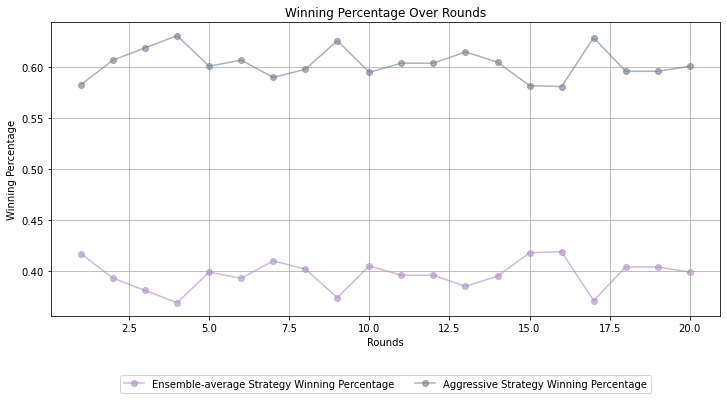

In [39]:
# Line plot for wealth change

plt.figure(figsize=(12, 6))

for round_num in all_p1_wealth:
    plt.plot(all_p1_wealth[round_num], color='#af8dc3', alpha=0.5)
    plt.plot(all_p2_wealth[round_num], color='slategrey', alpha=0.5)
custom_lines = [
    Line2D([0], [0], color='#af8dc3', lw=4, alpha=0.8),
    Line2D([0], [0], color='slategrey', lw=4, alpha=0.8)
]
plt.legend(custom_lines, ['Ensemble-average Strategy Player Wealth', 'Aggressive Strategy Player Wealth'], 
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, borderaxespad=0.)

plt.title(f'Wealth Over {len(all_p1_wealth)} Rounds Matches')
plt.xlabel('Number of Hands in One Round')
plt.ylabel('Wealth')
plt.subplots_adjust(bottom=0.2)
plt.grid(True)
plt.show()


# Line plot for win prob.
# data preparation

round_nums = list(all_p1_wins_prob.keys())
p1_win_probs = [all_p1_wins_prob[round_num] for round_num in round_nums]
p2_win_probs = [all_p2_wins_prob[round_num] for round_num in round_nums]
# fig
plt.figure(figsize=(12, 6))
plt.plot(round_nums, p1_win_probs, label='Ensemble-average Strategy Winning Percentage', color='#af8dc3', marker='o',alpha=0.6)
plt.plot(round_nums, p2_win_probs, label='Aggressive Strategy Winning Percentage', color='slategrey', marker='o',alpha=0.6)

plt.title('Winning Percentage Over Rounds')
plt.xlabel('Rounds')
plt.ylabel('Winning Percentage')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2, borderaxespad=0.)
plt.subplots_adjust(bottom=0.2)
plt.grid(True)
plt.show()